# Notebook of comparison VAE and geometric VAE

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

**Util functions**

In [3]:
def make_joint_df(arrays, labels):
    all_arrays = np.concatenate(arrays)
    all_labels = []
    for i,lab in enumerate(labels):
        all_labels += [lab for _ in range(len(arrays[i]))]
    return pd.DataFrame({"values": all_arrays,
                         "labels": all_labels})

## Initialize the two different configurations 

General module hparams

In [6]:
datamodule={'path': PROJECT_FOLDER / 'data/hein_et_al/processed/unperturbed_time_course_host.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'cluster'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 128, 
            'num_workers': 2}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [7]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [10]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geodesic_ae = GeodesicAE(**geodesic).eval()

In [42]:
# vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)

In [43]:
# vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_vae_lib.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_geometric_lib.ckpt")["state_dict"])

In [11]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geometric_lib.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geodesic_ae.ckpt")["state_dict"])

<All keys matched successfully>

### Compute UMAPs

In [12]:
adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geodesic_amortized_real, adata_geodesic_z, adata_geodesic_mu = real_reconstructed_cells_adata(geodesic_ae, datamodule, process_amortized_adata=True, log1p=False, vae=False, model_type="geodesic").values()

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/s

In [21]:
adata_vae_z.obs["cluster"] = adata_vae_z.obs["cluster"].astype("category")
adata_geometric_z.obs["cluster"] = adata_geometric_z.obs["cluster"].astype("category")
adata_geodesic_z.obs["cluster"] = adata_geodesic_z.obs["cluster"].astype("category")

Plot the UMAP results

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


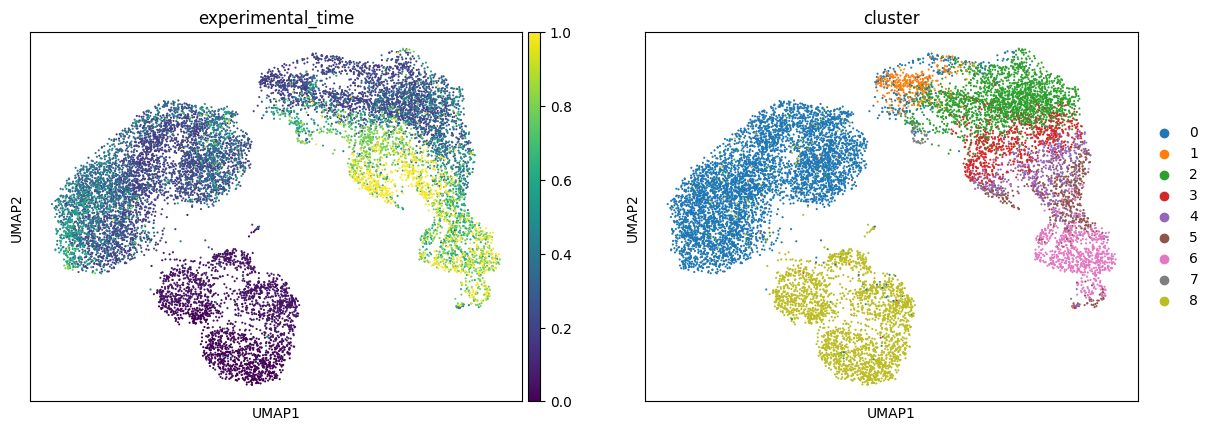

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


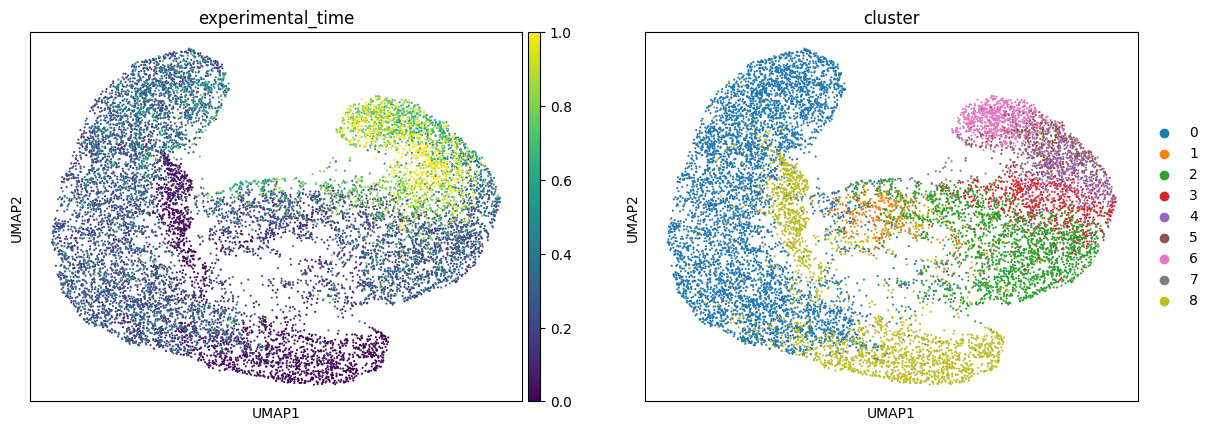

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


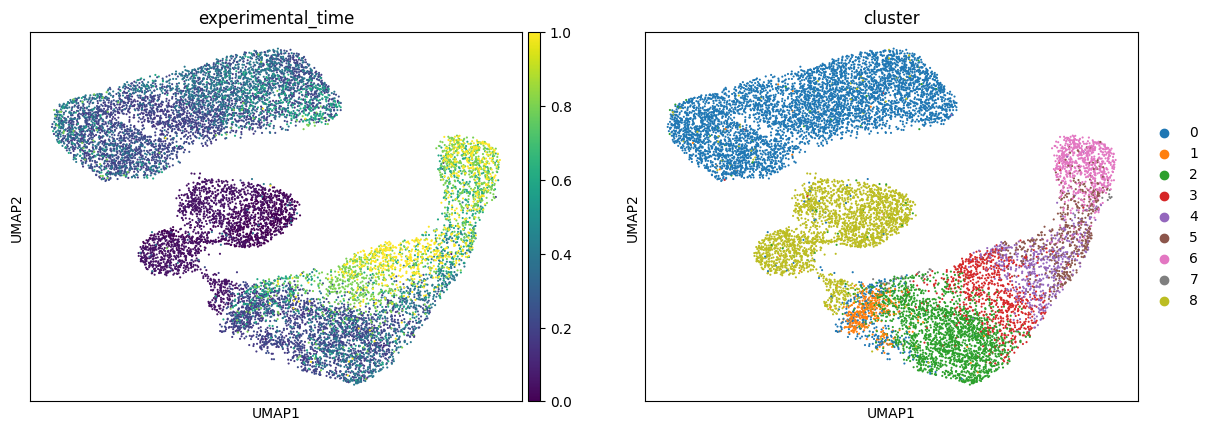

In [22]:
sc.pl.umap(adata_vae_z, color=["experimental_time", "cluster"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "cluster"])
sc.pl.umap(adata_geodesic_z, color=["experimental_time", "cluster"])

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


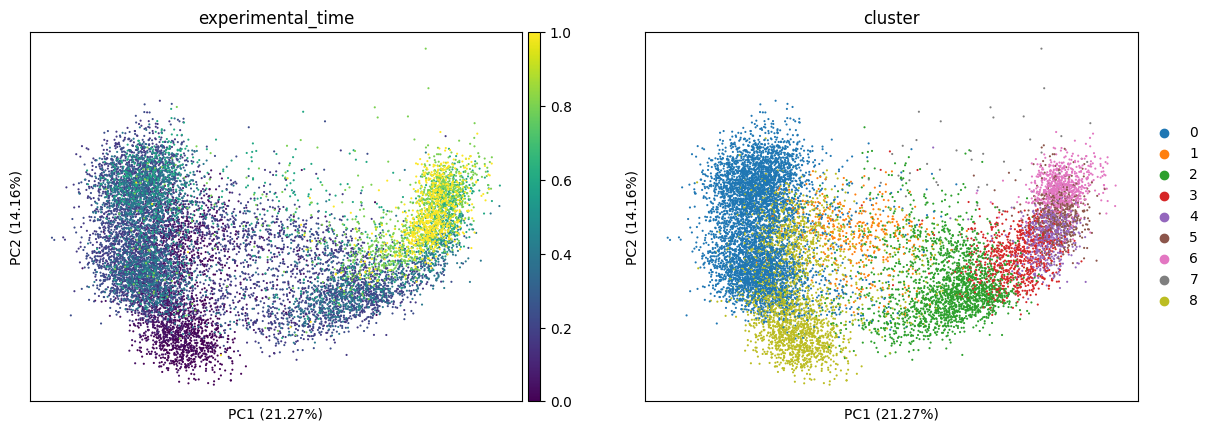

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


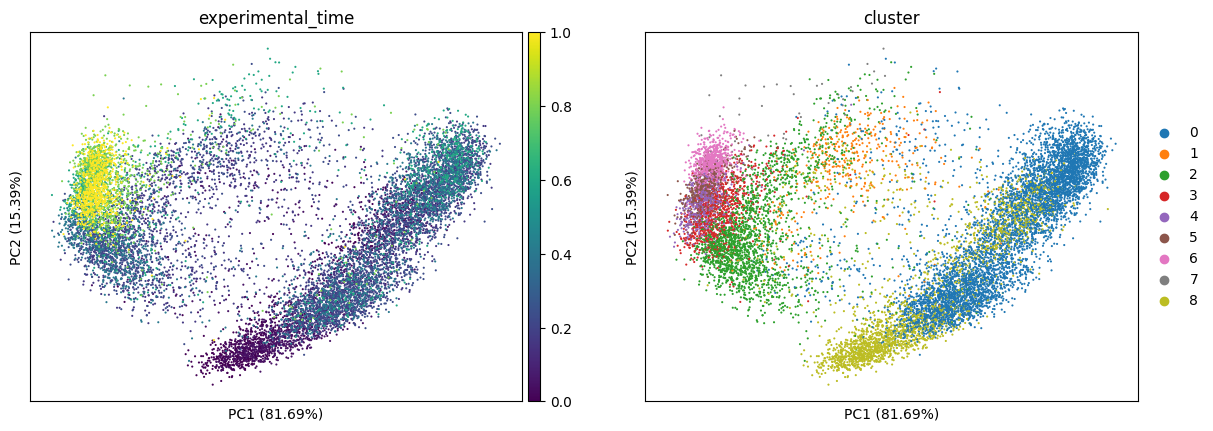

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


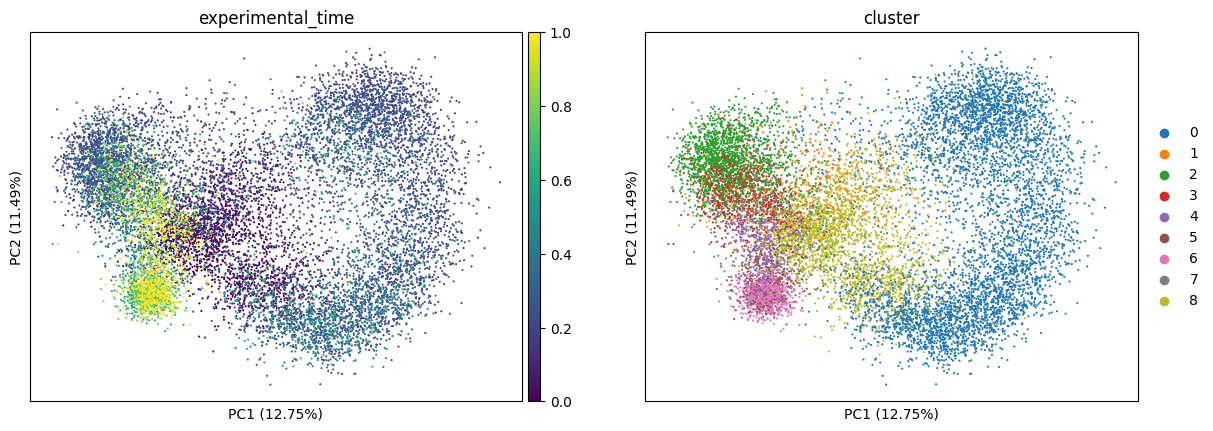

In [23]:
sc.pl.pca(adata_vae_z, color=["experimental_time", "cluster"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "cluster"], annotate_var_explained=True)
sc.pl.pca(adata_geodesic_z, color=["experimental_time", "cluster"],  annotate_var_explained=True)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


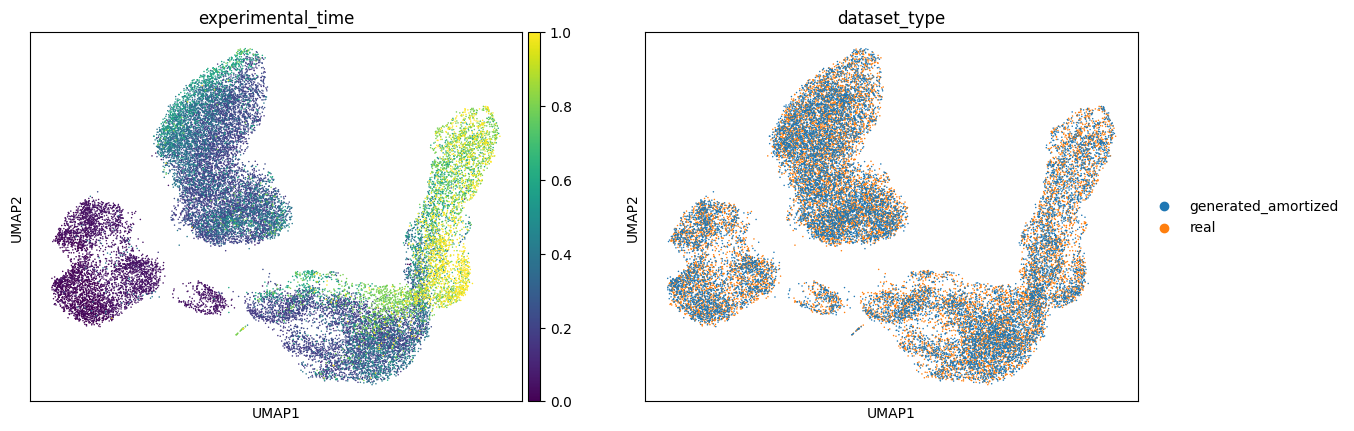

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


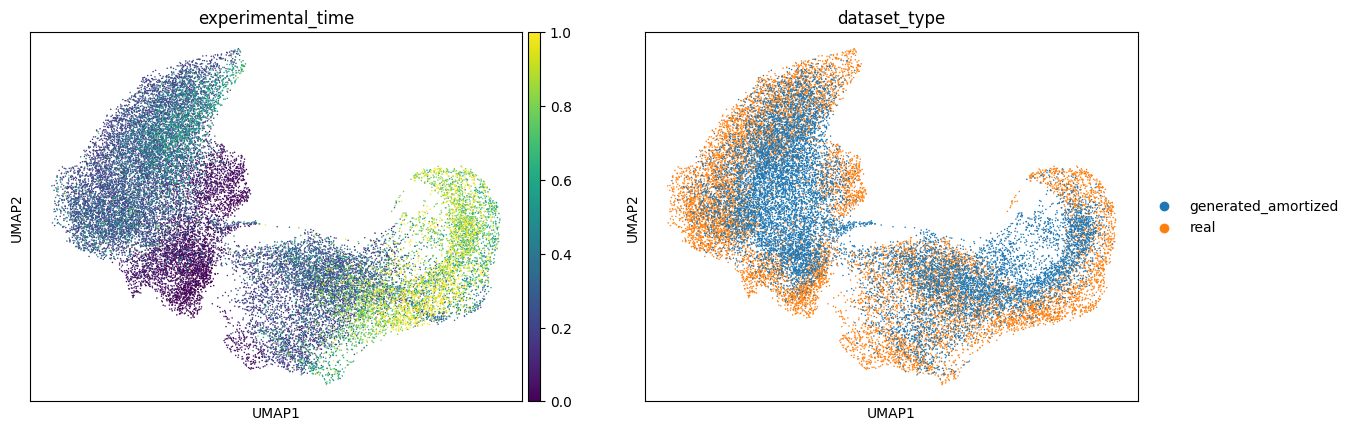

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


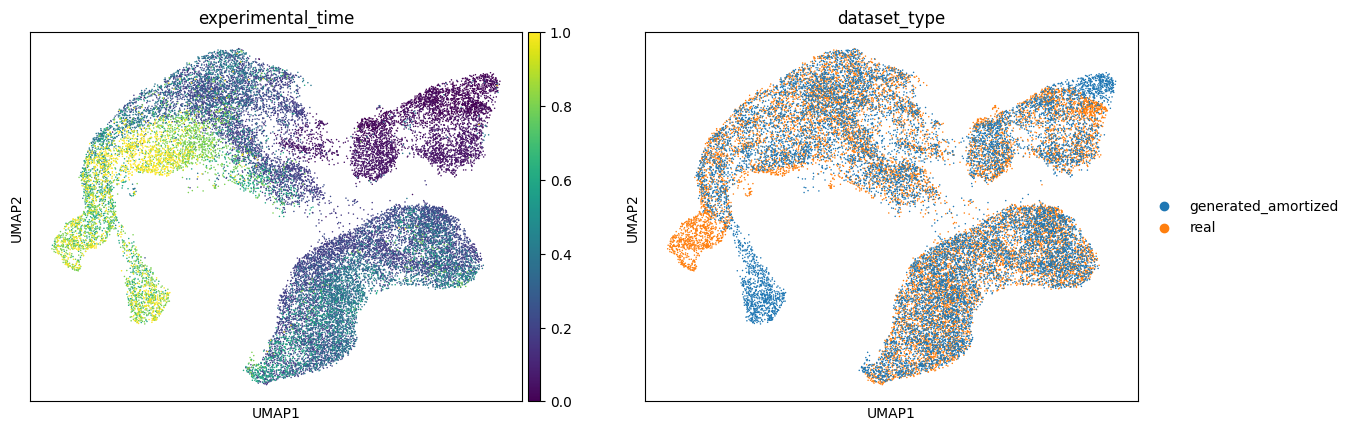

In [24]:
sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geodesic_amortized_real, color=["experimental_time", "dataset_type"])

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


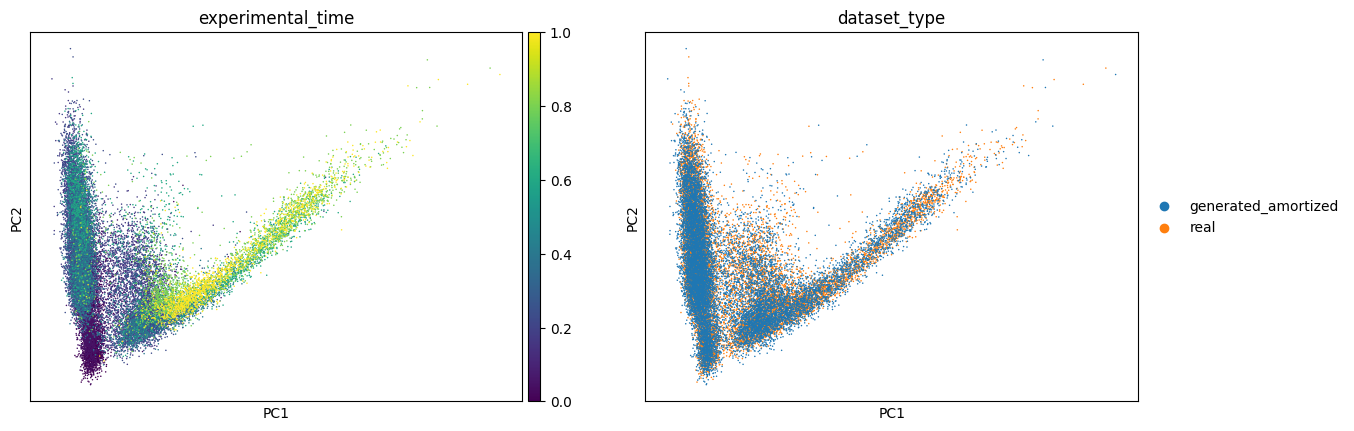

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


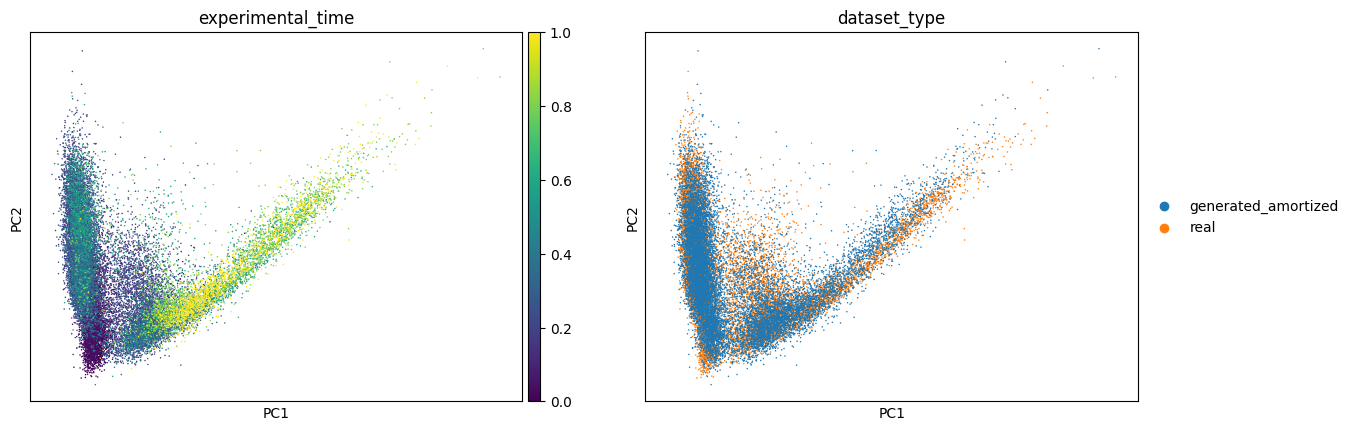

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


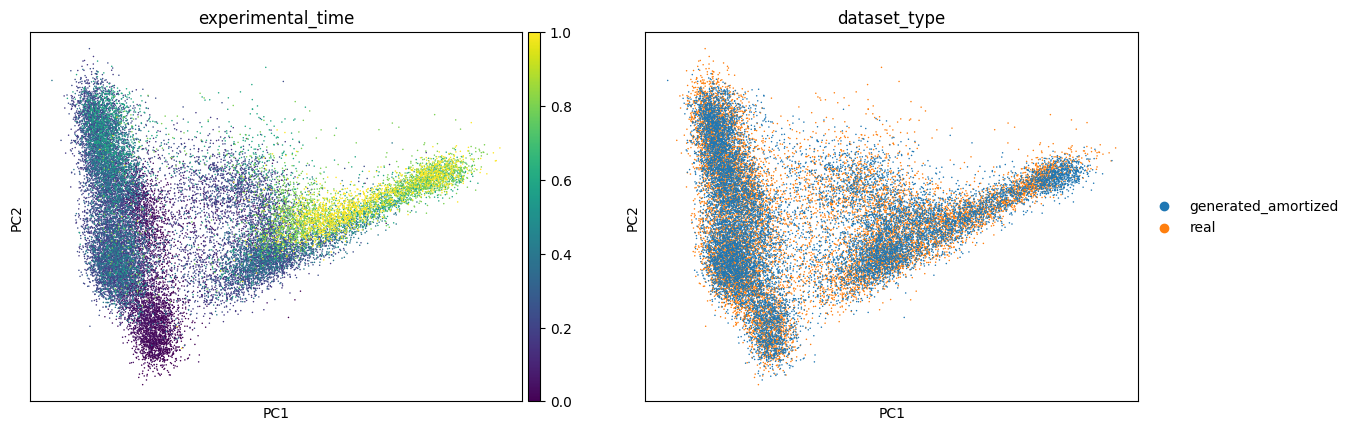

In [25]:
sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geodesic_amortized_real, color=["experimental_time", "dataset_type"])

Check reconstruction umap

In [26]:
# from pytorch_lightning import Trainer

# trainer_vae = Trainer(inference_mode=False)
# trainer_geometric = Trainer(inference_mode=False)

**Save anndata**

In [54]:
PROJECT_FOLDER / "data/hein_et_al/flat/"

PosixPath('/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/flat')

In [55]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_lib_complete.h5ad")

In [56]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_flat_lib_complete.h5ad")

In [28]:
# adata_geodesic_z.layers["X_latents"] = adata_geodesic_z.X.copy()
# adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_geodesic_lib.h5ad")

**Compare latents**

In [57]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


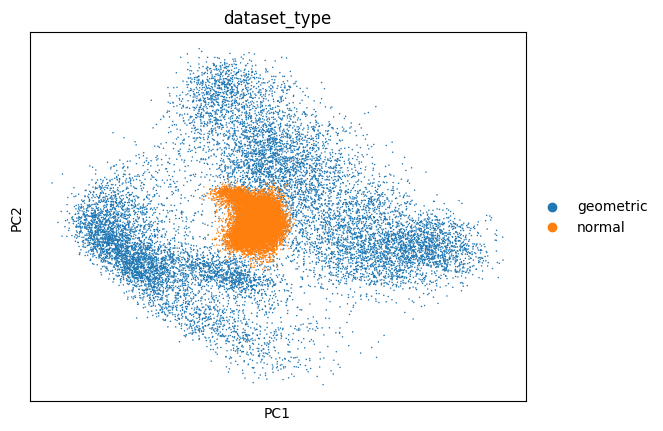

In [58]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


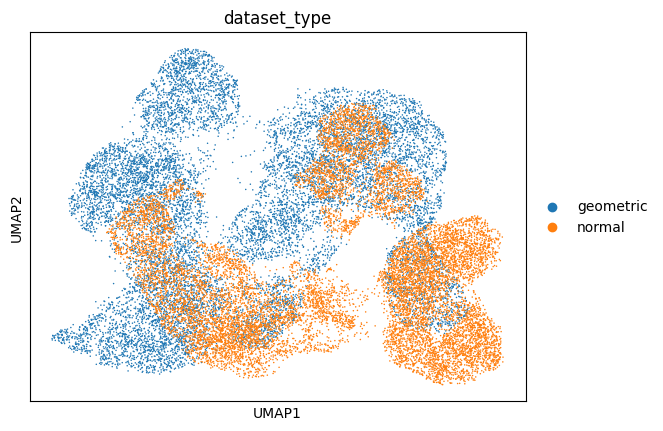

In [59]:
sc.pl.umap(concat, color="dataset_type")

**Latent sizes**

<Axes: xlabel='values', ylabel='Count'>

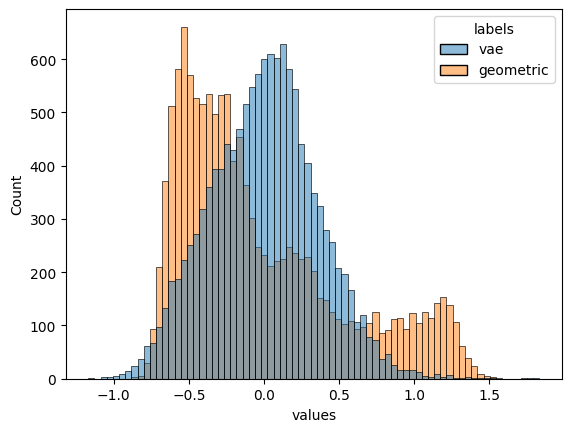

In [60]:
vae_mean_df = make_joint_df([adata_vae_z.X.mean(1), adata_geometric_z.X.mean(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare real and generated data**

In [61]:
adata_real = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="real"]
adata_generated_vae = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geometric = adata_geometric_amortized_real[adata_geometric_amortized_real.obs['dataset_type']=="generated_amortized"]

adata_real.layers["X_norm"] = np.exp(adata_real.X)-1
adata_generated_vae.layers["X_norm"] = np.exp(adata_generated_vae.X)-1
adata_generated_geometric.layers["X_norm"] = np.exp(adata_generated_geometric.X)-1

In [62]:
adata_generated_vae.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 3., 2., 0.],
       ...,
       [0., 0., 0., ..., 8., 4., 0.],
       [0., 0., 0., ..., 4., 4., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

<Axes: xlabel='values', ylabel='Count'>

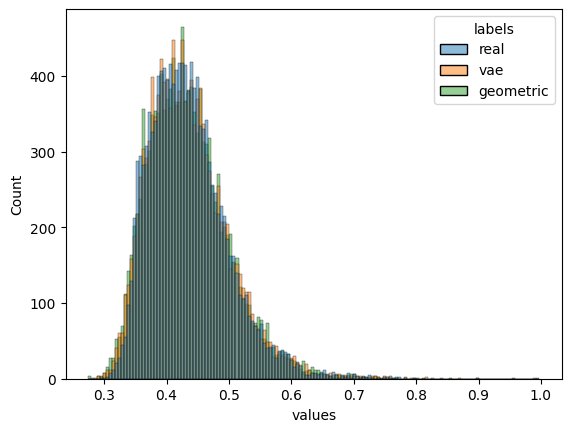

In [63]:
vae_mean_df = make_joint_df([adata_real.X.mean(1), 
                             adata_generated_vae.X.mean(1), 
                             adata_generated_geometric.X.mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

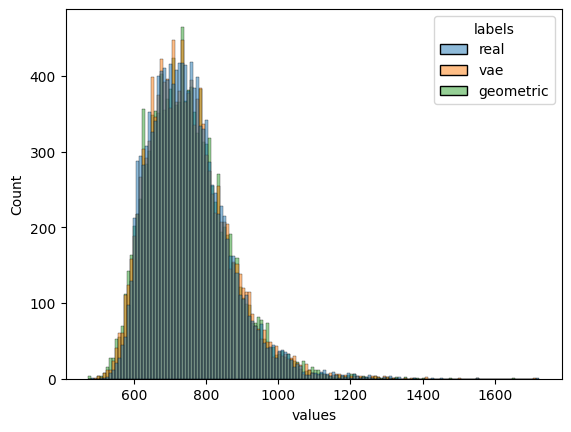

In [64]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

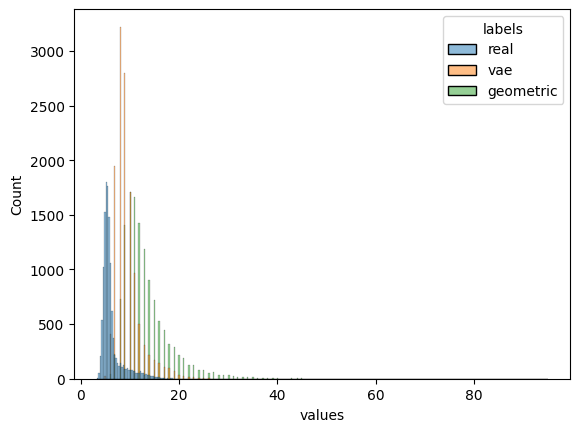

In [65]:
vae_mean_df = make_joint_df([adata_real.X.max(1), 
                             adata_generated_vae.X.max(1), 
                             adata_generated_geometric.X.max(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

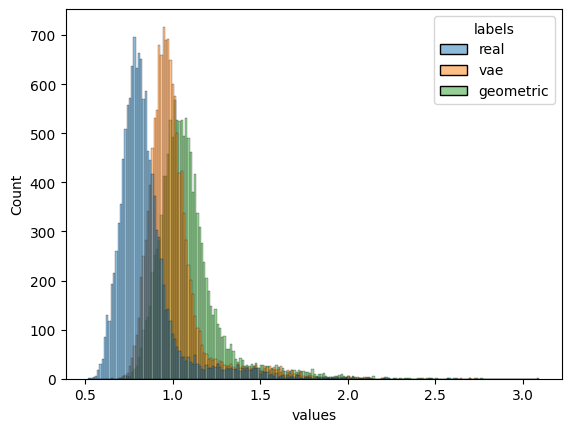

In [66]:
vae_mean_df = make_joint_df([adata_real.X.std(1), 
                             adata_generated_vae.X.std(1), 
                             adata_generated_geometric.X.std(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

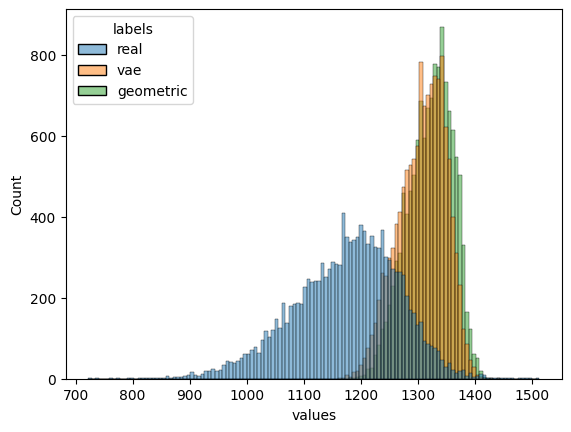

In [67]:
vae_mean_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_vae.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

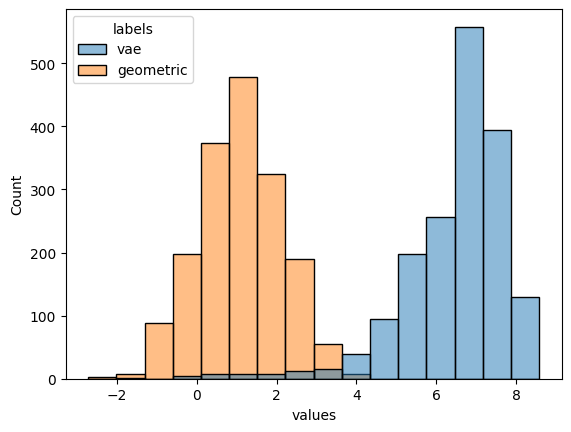

In [68]:
vae_mean_df = make_joint_df([vae.theta.detach().cpu().numpy(), 
                             geometric_vae.theta.detach().cpu().numpy()], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

In [69]:
torch.exp(geometric_vae.theta)

tensor([0.4818, 2.1762, 7.2397,  ..., 8.0512, 7.9185, 7.3576], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [70]:
torch.exp(vae.theta)

tensor([ 109.8402,  734.5538,  363.7724,  ..., 2933.0808, 3004.5212,
        1346.9189], device='cuda:0', grad_fn=<ExpBackward0>)

In [71]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/processed/unperturbed_time_course_host.h5ad")

In [72]:
adata.layers["X_norm"].A.max()

24.73482

In [73]:
adata.var

ENSMBL          gene ID     mt  is_host  \
gene ID                                                             
RP11-54O7.3      ENSG00000223764      RP11-54O7.3  False     True   
SAMD11           ENSG00000187634           SAMD11  False     True   
PLEKHN1          ENSG00000187583          PLEKHN1  False     True   
HES4             ENSG00000188290             HES4  False     True   
ISG15            ENSG00000187608            ISG15  False     True   
...                          ...              ...    ...      ...   
ORFS369W                ORFS369W         ORFS369W  False    False   
ORFS371W_(US34)  ORFS371W_(US34)  ORFS371W_(US34)  False    False   
ORFS372W                ORFS372W         ORFS372W  False    False   
ORFS373W                ORFS373W         ORFS373W  False    False   
ORFS376W                ORFS376W         ORFS376W  False    False   

                 highly_variable     means  dispersions  dispersions_norm  
gene ID                                                                    
RP11-54O7.3                 True  0.020879    -0.245798          0.659897  
SAMD11                      True  0.147365    -0.246578          1.700293  
PLEKHN1                     True  0.031576    -0.273150          0.542630  
HES4                        True  0.838479    -0.819448          0.765280  
ISG15                       True  1.624209    -0.516369          2.157820  
...                          ...       ...          ...               ...  
ORFS369W                    True  0.885551     0.476379          3.091739  
ORFS371W_(US34)             True  0.462203     0.195950          3.810770  
ORFS372W                    True  0.811727     0.506042          4.248973  
ORFS373W                    True  1.005489     0.441661          3.181592  
ORFS376W                    True  0.206811     0.338840          6.168636  

[1727 rows x 8 columns]